In [22]:
import sys
sys.path.append("../utils")
from utils import load_data, create_mlp_sae
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Import Keras for implementing autoencoders
import keras
from keras.models import Sequential
from keras.layers import Input, Dense
from pathlib import Path
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
train, test, train_target = load_data(raw = False, categorical=False)

In [24]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(train, train_target, test_size=0.2, random_state=42)

In [25]:
# Define the autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 50

# Set the encoding dimension
input_layer = keras.layers.Input(shape=(input_dim,))
encoder = keras.layers.Dense(encoding_dim, activation="relu")(input_layer)
decoder = keras.layers.Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the autoencoder architecture
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 19907)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │       995,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19907)          │     1,015,257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,010,657 (7.67 MB)

 Trainable params: 2,010,657 (7.67 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.1372 - val_loss: 0.9422
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9517 - val_loss: 0.9146
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9138 - val_loss: 0.8981
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9000 - val_loss: 0.8858
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8966 - val_loss: 0.8763
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8693 - val_loss: 0.8687
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8708 - val_loss: 0.8629
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.8313 - val_loss: 0.8581
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8240 - val_loss: 0.8541
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8312 - val_loss: 0.8512


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Encoded Features Shape (Train): (593, 50)
Encoded Features Shape (Test): (149, 50)


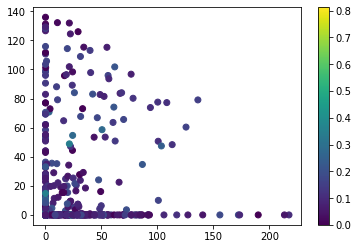

In [27]:
# Use encoder part of the autoencoder for feature selection
encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
encoded_features_train = encoder.predict(X_train)
encoded_features_test = encoder.predict(X_test)

# Display the shape of extracted features
print("Encoded Features Shape (Train):", encoded_features_train.shape)
print("Encoded Features Shape (Test):", encoded_features_test.shape)
# plot all encoded features
plt.scatter(encoded_features_train[:,0], encoded_features_train[:,1], c = y_train['AAC'], cmap='viridis')
plt.colorbar()
plt.show()

In [28]:
# --- Encoded Features ---
# Fit a linear regression model using the encoded features
encoded_model = LinearRegression()
encoded_model.fit(encoded_features_train, y_train)

# Make predictions on the test set
y_pred_encoded = encoded_model.predict(encoded_features_test)

# Calculate regression metrics
mse_encoded = mean_squared_error(y_test, y_pred_encoded)
r2_encoded = r2_score(y_test, y_pred_encoded)

# Calculate Spearman's rank correlation for encoded features
spearman_encoded, p_value_encoded = spearmanr(y_test, y_pred_encoded)

print("--- Encoded Features ---")
print("Mean Squared Error (MSE):", mse_encoded)
print("R-squared (R²):", r2_encoded)
print("Spearman's Correlation (ρ):", spearman_encoded)
print("P-value (Spearman):", p_value_encoded)

# --- Non Encoded Features ---
# Fit a linear regression model using the non-encoded features
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate regression metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate Spearman's rank correlation for non-encoded features
spearman_non_encoded, p_value_non_encoded = spearmanr(y_test, y_pred)

print("--- Non Encoded Features ---")
print("Mean Squared Error (MSE):", mse)
print("R-squared (R²):", r2)
print("Spearman's Correlation (ρ):", spearman_non_encoded)
print("P-value (Spearman):", p_value_non_encoded)


--- Encoded Features ---
Mean Squared Error (MSE): 0.00558872870916726
R-squared (R²): 0.2534505521611147
Spearman's Correlation (ρ): 0.42186506608494234
P-value (Spearman): 8.395464173159713e-08
--- Non Encoded Features ---
Mean Squared Error (MSE): 0.006525344875489466
R-squared (R²): 0.12833618032591332
Spearman's Correlation (ρ): 0.40826265940762246
P-value (Spearman): 2.3594136881805703e-07


# VAE

In [29]:
from src.utils.vae import VAE, train, encode_data, plot_latent_space
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

In [30]:
# Use VAE for feature selection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Convert to tensor
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
X_test_tensor = torch.tensor(scaler.transform(X_test), dtype=torch.float32)
test_dataset = TensorDataset(X_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

input_dim = X_train.shape[1]
latent_dim = 20
model = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train(model, train_loader,test_loader, optimizer, epochs=10, device=device)

Epoch 1/10, Train Loss: 1388.8620, Val Loss: 1143.6420
Epoch 2/10, Train Loss: 381.7426, Val Loss: 688.1967
Epoch 3/10, Train Loss: 251.9232, Val Loss: 661.7448
Epoch 4/10, Train Loss: 233.5784, Val Loss: 653.6871
Epoch 5/10, Train Loss: 225.5386, Val Loss: 646.8406
Epoch 6/10, Train Loss: 219.7022, Val Loss: 641.3820
Epoch 7/10, Train Loss: 215.5105, Val Loss: 644.9194
Epoch 8/10, Train Loss: 213.8774, Val Loss: 641.6607
Epoch 9/10, Train Loss: 210.9167, Val Loss: 632.5585
Epoch 10/10, Train Loss: 207.4435, Val Loss: 631.5226


In [31]:
# Extract latent features from X_train
latent_train = encode_data(model, X_train_tensor, device)
latent_test = encode_data(model, X_test_tensor, device)
latent_train.shape

torch.Size([593, 20])

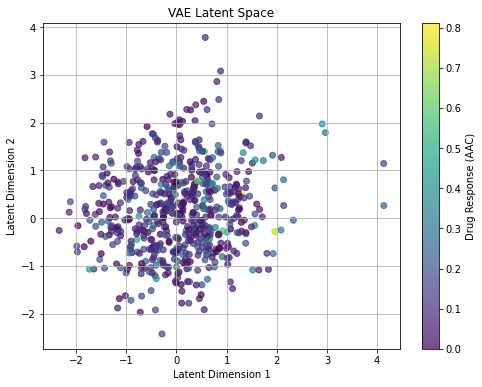

In [32]:
# Plot the latent space
plot_latent_space(latent_train, y_train['AAC'])

In [33]:
vae_encoded_model = LinearRegression()
vae_encoded_model.fit(latent_train, y_train)
y_pred_vae = vae_encoded_model.predict(latent_test)
# Calculate regression metrics
mse_vae = mean_squared_error(y_test, y_pred_vae)
r2_vae = r2_score(y_test, y_pred_vae)
spearman_vae, p_value_vae = spearmanr(y_test, y_pred_vae)

# Print the results
print("--- VAE Encoded Features ---")
print("Mean Squared Error (MSE):", mse_vae)
print("R-squared (R²):", r2_vae)
print("Spearman's Correlation (ρ):", spearman_vae)

--- VAE Encoded Features ---
Mean Squared Error (MSE): 0.006900349067689411
R-squared (R²): 0.07824264614435328
Spearman's Correlation (ρ): 0.3036262503413641


In [ ]:
from sklearn.neural_network import MLPRegressor
# Use a MLPRegressor
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
    activation='relu',
    solver='adam',
    learning_rate='adaptive',
    max_iter=1000,
    random_state=42
)
mlp_model.fit(latent_train, y_train['AAC'])
y_pred_mlp = mlp_model.predict(latent_test)
# Calculate regression metrics
mse_mlp = mean_squared_error(y_test['AAC'], y_pred_mlp)
r2_mlp = r2_score(y_test['AAC'], y_pred_mlp)
spearman_mlp, p_value_mlp = spearmanr(y_test['AAC'], y_pred_mlp)
# Print
print("--- MLP Regressor ---")
print("Mean Squared Error (MSE):", mse_mlp)
print("R-squared (R²):", r2_mlp)
print("Spearman's Correlation (ρ):", spearman_mlp)


--- MLP Regressor ---
Mean Squared Error (MSE): 0.008046852520330727
R-squared (R²): -0.07490873479685645
Spearman's Correlation (ρ): 0.25131892918469356


# Data Augmentation

In [39]:
# Add the project root directory to the Python path
project_root = Path().resolve().parent.parent
sys.path.append(str(project_root))
# Load the data
data_path = project_root / 'data' / 'preprocessed'
train_augmented = pd.read_csv(data_path / 'train_augmented.csv')

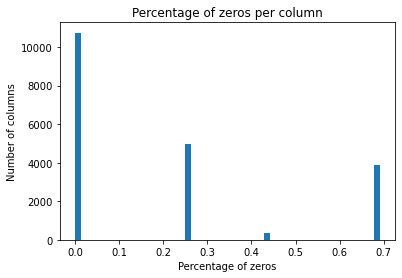

A3GALT2    0.690962
AADACL3    0.690962
AADACL4    0.690962
AARD       0.690962
AARS1      0.690962
             ...   
ZSCAN5B    0.690962
ZSCAN5C    0.690962
ZSWIM4     0.690962
ZSWIM9     0.690962
ZUP1       0.690962
Length: 3879, dtype: float64


In [40]:
# Plot percentage of samples == 0  per columns
percentage_zeros = (train_augmented == 0).mean()
percentage_zeros.plot(kind='hist', bins=50)
plt.xlabel('Percentage of zeros')
plt.ylabel('Number of columns')
plt.title('Percentage of zeros per column')
plt.show()
# Print all columns with more than 40% zeros
print(percentage_zeros[percentage_zeros > 0.6])

In [ ]:
# Get all columns with more than 60% zeros
columns_to_drop = percentage_zeros[percentage_zeros > 0.6].index
# drop these columns
train_augmented = train_augmented.drop(columns=columns_to_drop)


In [43]:
X_train = X_train.drop(columns=columns_to_drop)

In [49]:
X_test = X_test.drop(columns=columns_to_drop)

In [44]:
# Split the data
new_X_train, new_X_test = train_test_split(train_augmented, test_size=0.2, random_state=42)

In [46]:
# Define the autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 50

# Set the encoding dimension
input_layer = keras.layers.Input(shape=(input_dim,))
encoder = keras.layers.Dense(encoding_dim, activation="relu")(input_layer)
decoder = keras.layers.Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the autoencoder architecture
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16028)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │       801,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16028)          │       817,428 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,618,878 (6.18 MB)

 Trainable params: 1,618,878 (6.18 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
autoencoder.fit(new_X_train, new_X_train, epochs=10, batch_size=32, shuffle=True, validation_data=(new_X_test, new_X_test))

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.9666 - val_loss: 0.8348
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8157 - val_loss: 0.8052
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8038 - val_loss: 0.7865
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7728 - val_loss: 0.7745
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7506 - val_loss: 0.7668
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.7323 - val_loss: 0.7611
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7306 - val_loss: 0.7577
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7327 - val_loss: 0.7552
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7192 - val_loss: 0.7532
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.7092 - val_loss: 0.7519


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Encoded Features Shape (Train): (593, 50)
Encoded Features Shape (Test): (149, 50)


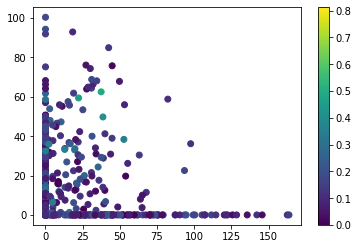

In [50]:
# Use encoder part of the autoencoder for feature selection
encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
encoded_features_train = encoder.predict(X_train)
encoded_features_test = encoder.predict(X_test)

# Display the shape of extracted features
print("Encoded Features Shape (Train):", encoded_features_train.shape)
print("Encoded Features Shape (Test):", encoded_features_test.shape)
# plot all encoded features
plt.scatter(encoded_features_train[:,0], encoded_features_train[:,1], c = y_train['AAC'], cmap='viridis')
plt.colorbar()
plt.show()

In [51]:
# --- Encoded Features ---
# Fit a linear regression model using the encoded features
encoded_model = LinearRegression()
encoded_model.fit(encoded_features_train, y_train)

# Make predictions on the test set
y_pred_encoded = encoded_model.predict(encoded_features_test)

# Calculate regression metrics
mse_encoded = mean_squared_error(y_test, y_pred_encoded)
r2_encoded = r2_score(y_test, y_pred_encoded)

# Calculate Spearman's rank correlation for encoded features
spearman_encoded, p_value_encoded = spearmanr(y_test, y_pred_encoded)

print("--- Encoded Features ---")
print("Mean Squared Error (MSE):", mse_encoded)
print("R-squared (R²):", r2_encoded)
print("Spearman's Correlation (ρ):", spearman_encoded)
print("P-value (Spearman):", p_value_encoded)

--- Encoded Features ---
Mean Squared Error (MSE): 0.006870349579105143
R-squared (R²): 0.08225001576336843
Spearman's Correlation (ρ): 0.3238566332820426
P-value (Spearman): 5.601142675714886e-05
